In [10]:
from point_in_polygon import *
from itertools import chain
import geopandas as gpd
from matplotlib import pyplot as plt
from math import ceil

# Load the alti table

In [2]:
from alti_data import AltiData

ascii_file_dir_path = "../data/input/bd_alti/"
ascii_file_name = "BDALTIV2_25M_FXX_0825_6550_MNT_LAMB93_IGN69.asc"
ascii_file_path = ascii_file_dir_path + ascii_file_name

alti_data = AltiData(ascii_file_path)
# print(alti_data.alti_table)

# Load the field table

In [ ]:
shapefile_dir_path = '/home/bertrand/Documents/Projet Indus/WazeTT/data/input/bd_carto/'
shapefile_name = 'MASSIF_BOISE.shp'
shapefile_path = shapefile_dir_path + shapefile_name

In [ ]:
# Conversion of a pair of files (.shp + .shx) into a list of POLYGON included into the ASCII table Bounding Box
import geopandas as gpd

gdf = gpd.read_file(
    shapefile_path,
    bbox=ascii_table_bb_coord_lamb93,
)

shapefile_polygones_wgs84 = gdf['geometry']
print(shapefile_polygones_wgs84[0])
# TODO : visualize these data with follium

# Creation of the cells center coordinates table

In [3]:
# Calculate cells center coordinates table
cells_center_coordinates = [[None for col in range(alti_data.ncols)] for row in range(alti_data.nrows)]
nw_coord_ref_lamb93 = (
                        alti_data.xllcorner_lamb93 + alti_data.cellsize/2,
                        alti_data.yllcorner_lamb93 - alti_data.cellsize/2
                    )

for row in range(len(cells_center_coordinates)):
    for col in range(len(cells_center_coordinates[0])):

        cell_center_coord = (
            nw_coord_ref_lamb93[0]+(col)*alti_data.cellsize,
            nw_coord_ref_lamb93[1]-(row)*alti_data.cellsize
        )
        cells_center_coordinates[row][col] = cell_center_coord


# Creation of the field table

In [4]:
# Initializes the empty field 2D table
field_table = [['sand' for col in range(alti_data.ncols)] for row in range(alti_data.nrows)]
print('Number of rows : {}'.format(len(field_table[0])))
print('Number of columns : {}'.format(len(field_table)))
print('Cells content : {}'.format(field_table[0][0]))

Number of rows : 1000
Number of columns : 1000
Cells content : sand


# Calculation of the coordinates of the dummy polygon of the second field to work with

In [5]:
#alti_bb_coord = alti_data.calc_bb_coordinates()

dummy_rectangle_coord = {}
width = alti_data.ncols*alti_data.cellsize
height = alti_data.nrows*alti_data.cellsize
dummy_rectangle_coord['nw'] = (
                                alti_data.xllcorner_lamb93+1*width/4,
                                alti_data.yllcorner_lamb93-1*height/4,
                            )
dummy_rectangle_coord['ne'] = (
                                alti_data.xllcorner_lamb93+3*width/4,
                                alti_data.yllcorner_lamb93-1*height/4,
                            )
dummy_rectangle_coord['se'] = (
                                alti_data.xllcorner_lamb93+3*width/4,
                                alti_data.yllcorner_lamb93-3*height/4,
                            )
dummy_rectangle_coord['sw'] = (
                                alti_data.xllcorner_lamb93+1*width/4,
                                alti_data.yllcorner_lamb93-3*height/4,
                            )
for k,v in dummy_rectangle_coord.items():
    print(k, v)

nw (831237.5, 6518762.5)
ne (843737.5, 6518762.5)
se (843737.5, 6506262.5)
sw (831237.5, 6506262.5)


# Create the polygon

In [6]:
from shapely.geometry import Polygon

dummy_rectangle_polygon = Polygon([
                                    dummy_rectangle_coord['nw'],
                                    dummy_rectangle_coord['ne'],
                                    dummy_rectangle_coord['se'],
                                    dummy_rectangle_coord['sw']
                                ])


# Calculate polygon bounding box

In [8]:
polygon_bb_bounds = dummy_rectangle_polygon.bounds

from coordinates_utils import bb_bounds_to_coord
polygon_bb_coordinates = bb_bounds_to_coord(polygon_bb_bounds)
print(polygon_bb_coordinates)

{'nw': (831237.5, 6518762.5), 'ne': (843737.5, 6518762.5), 'se': (843737.5, 6506262.5), 'sw': (831237.5, 6506262.5)}
831237.5


# Calculate indexes of polygons BB relatively to the 2D altitudes table

In [15]:
Xll_min = polygon_bb_coordinates["nw"][0]
Xll_max = polygon_bb_coordinates["ne"][0]
Yll_min = polygon_bb_coordinates["sw"][1]
Yll_max = polygon_bb_coordinates["ne"][1]

j_min = ceil(abs(alti_data.xllcorner_lamb93-Xll_min)/alti_data.cellsize) - 1
j_max = ceil(abs(alti_data.xllcorner_lamb93-Xll_max)/alti_data.cellsize) - 1
i_min = ceil(abs(alti_data.yllcorner_lamb93-Yll_max)/alti_data.cellsize) - 1
i_max = ceil(abs(alti_data.yllcorner_lamb93-Yll_min)/alti_data.cellsize) - 1

print(j_min, j_max, i_min, i_max)

249 749 249 749


# Convert the polygon into a vector

In [7]:
# Pass
len(field_table)

1000

# (Temporary) Create a vector from the dummy_rectangle_coord

In [16]:
V = [dummy_rectangle_coord['nw'], dummy_rectangle_coord['ne'], dummy_rectangle_coord['se'], dummy_rectangle_coord['sw']]

# Fill the polygon into the field map

In [17]:
from winding_point_utils import wn_PnPoly
for i in range(i_min,i_max): # x = j = rows
    for j in range(j_min,j_max): # y = i = columns
        if wn_PnPoly(cells_center_coordinates[i][j],V):# if true, the pixel is inside the shape
            field_table[i][j] = 'wood'

<function matplotlib.pyplot.show(close=None, block=None)>

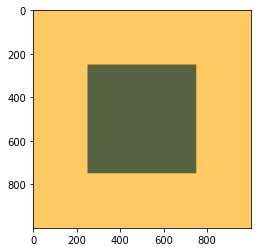

In [18]:
###### Objectif : Remplir la liste avec winding point ######
import numpy as np
import matplotlib.pyplot as plt
img = np.zeros((1000,1000,3))
for i in range(1000):
    for j in range(1000):
        if field_table[i][j] == 'wood':
            img[i][j][0] = 0.34
            img[i][j][1] = 0.39
            img[i][j][2] = 0.26
        else:
            img[i][j][0] = 1
            img[i][j][1] = 0.79
            img[i][j][2] = 0.39
plt.imshow(img)
plt.show





(930919.0999999201, 6444069.400002149) 
 (930995.9999999201, 6444135.700002148)


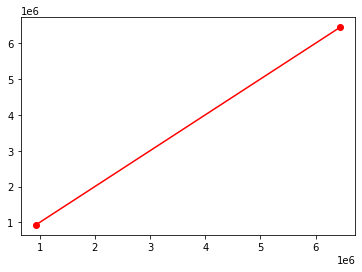

In [4]:
# gdf = gpd.read_file("AERODROME.shp")

# ####### 0  -  Trouver les 4 coins d'un shape #######

# a = gdf["geometry"][0].bounds[0]
# b = gdf["geometry"][0].bounds[1]
# c = gdf["geometry"][0].bounds[2]
# d = gdf["geometry"][0].bounds[3]
# point_1= (a,b)
# point_2 = (c,d)
# print(point_1, "\n", point_2)
# plt.plot(point_1, point_2 ,marker="o", color="red")
# plt.show()
# ####### 1  -  Convertire shp en liste python ####### 

# a = ([list(gdf["geometry"].geometry.exterior[row_id].coords) for row_id in range(gdf["geometry"].shape[0])])
# #print(int(a[0][0][0]))
# #print(a[0][0][1])
# #print(gdf["geometry"])

# ####### 2  -  Tester si le point est à l'intérieur  #######  

